# Assignment 1: Supervised learning, Linear models, and Loss functions

In this assignment, you're going to write your own methods to fit a linear model using either an OLS or LAD cost function.  

## Data set

We will examine some data representing the miles-per-gallon of 398 cars given other variables describing them:

1. mpg: continuous. The miles-per-gallon of the car.
2. cylinders: multi-valued discrete. Number of cylinders.
3. displacement: continuous. Engine displacement of the car.
4. horsepower: continuous. Total horsepower of the car.
5. weight: continuous. Weight in lbs.
6. acceleration: continuous. Acceleration 0-60mph in seconds.
9. car name: string (unique for each instance, DO NOT USE)

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


## Preliminaries

In [1]:
# Import all the necessary packages:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import scipy.optimize as so
from sklearn import linear_model
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
# Uncomment if using Google Colab or Kaggle Kernels.
# Imports the data using gdown.
# !gdown https://drive.google.com/uc?id=1PtY3ne37XA8Jk_cAf0Cd7JSRvEU8KDbp


## Part 1
### Question 1.1:


Read the `car_data.csv` file as a `pandas.DataFrame` and show its descriptive statistics.  Investigate the relationship between the cars' weight and their mpg by plotting a scatter plot of the `weight` (x axis) and `mpg` columns (y axis). Add an `alpha` (transparency of the plotted dots) in case some data are overlapping. Remember to label your axes.

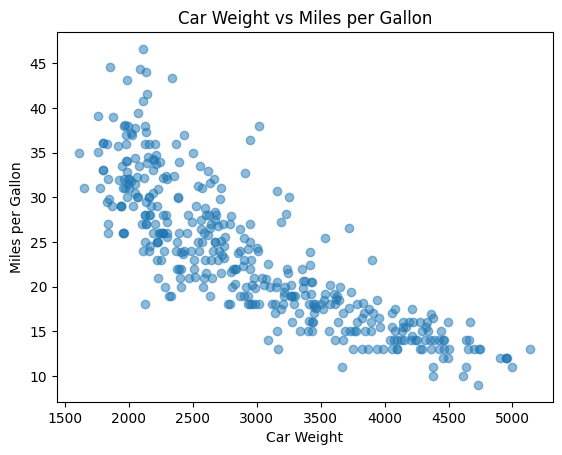

In [3]:
# YOUR CODE HERE

df = pd.read_csv('car_data.csv')
df.describe(include="all")

x = np.array(df["weight"])
y = np.array(df["MPG"])

plt.scatter(x, y, alpha=0.5)
plt.xlabel("Car Weight")
plt.ylabel("Miles per Gallon")
plt.title("Car Weight vs Miles per Gallon")
plt.show()

**Written answer: What do you see here? Discuss your findings**

I see that there is the possibility that there is a linear relationship between car weight and miles per gallon. The scatter plot appears to be curved, but the coefficients appear to be able to be written in a linear fashion. 

### Question 1.2: point

Recall that the linear model, we obtain predictions by computing

$$ \hat{\mathbf{y}} = \mathbf{X} \hat{\beta} $$

Here, $\mathbf{X}$ is a design matrix which includes a column of ones, $\hat{\beta}$ are coefficients, and $\hat{\mathbf{y}}$ are outcomes.  Write a function `linearModelPredict` to compute linear model predictions given data and a coefficient vector.  The function should take as it's arguments a 1d-array of coefficients `b` and the design matrix `X` as a 2d-array and return linear model predictions `yp`.

Test the function by setting

```
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
```

Call your function using these values.

Report $\hat{\mathbf{y}}$. Print the dimensionality of the numpy-array that you get.

Hint:  Read the documentation for `np.dot` or the `@` operator in `numpy`.

In [4]:
# Your code here.

def linearModelPredict(b,X):
    if len(b.shape) == 1:
        b = b.reshape(-1,1)
    if len(X.shape) == 1:
        X = X.reshape(-1,1)
    if b.shape[0] != X.shape[1]:
        raise Exception(f"Number of columns in b ({b.shape[0]}) is different from number of rows in X ({X.shape[1]})")
    yp = X@b
    return yp

print(linearModelPredict(b = np.array([0.1,0.3]), X = np.array([[1,0],[1,-1],[1,2]])))
print(linearModelPredict(b = np.array([0.1,0.3]), X = np.array([[1,0],[1,-1],[1,2]])).shape)

[[ 0.1]
 [-0.2]
 [ 0.7]]
(3, 1)


### Question 1.3:

Write a function `linearModelMSE` which computes and returns the mean squared error parameterized by $\beta$, as well as the gradient of the loss.  The function should take as its first argument a 1D-array `beta` of coefficients for the linear model, as its second argument the design matrix `X` as a 2D-array, and as its third argument a 1D-array `y` of observed outcomes. Recall that:

$$
MSE(y_i, \hat{y_i}) = \frac{1}{|I|} \sum_i (y_i - \hat{y_i})^2
$$
$$
\nabla MSE(y, \hat{y}) = -\frac{2}{|I|} \left[(y-\hat{y}) \cdot X\right]
$$

Test the function with the values

```
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2])
```

Report the loss and the gradient.



In [5]:
# Your code here.
def linearModelMSE(beta, X, y):
    yp = X@beta
    y_pred = yp.reshape(-1,1)
    y_real = np.array(y).reshape(-1,1)
    assert y_real.shape == y_pred.shape
    MSE = np.mean((y_real - y_pred)**2)
    GradientMSE = 2*( (y_pred-y_real).T@X)/len(y_real)
    return MSE, GradientMSE

print(f"The loss and gradient are {linearModelMSE(beta = np.array([0.1,0.3]), X = np.array([[1,0],[1,-1],[1,2]]), y = np.array([0,0.4,2]))}")
    

The loss and gradient are (np.float64(0.6866666666666666), array([[-1.2       , -1.33333333]]))


**Written answer**: To minimize the loss, do you need increase or decrease the value of the parameters?

**Your answer here.** To minimize the loss, we need to increase the value of the parameters

### Question 1.4:

Now that you've implemented a loss function in question 1.3, it is now time to minimize it!

Write a function `linearModelFit` to fit a linear model.  The function should take as its first argument the design matrix `X` as a 2D-array, as its second argument a 1D-array `y` of outcomes, and as its third argument a function  `lossfcn` which returns as a tuple the value of the loss, as well as the gradient of the loss. As a result, it should return the estimated betas and the $R^2$. Pass the argument `jac=True` to the `miminize` function so that it uses your gradient.

Test the function with the values:
```
X = np.array([[1,0],[1,-1],[1,2]])
y = np.array([0,0.4,2])
```

Report the best parameters and the fitted $R^2$.


In [6]:
# Your code here


X = np.array([[1,0],[1,-1],[1,2]])
y = np.array([0,0.4,2])


def linearModelFit(X, y, lossfcn):

    X = X.reshape(X.shape[0], -1)
    
    if not np.allclose(X[:, 0], 1):
        X = np.column_stack((np.ones(X.shape[0]), X)) # add intercept
        
    beta0 = np.zeros(X.shape[1],)
    
    def lossfcn1(beta):
        MSE, GradientMSE = lossfcn(beta, X, y)
        return MSE, GradientMSE

    result = so.minimize(lossfcn1, x0=beta0, jac=True)
    beta_opt = result.x
    y_pred = X@beta_opt
    ss_total = np.sum((y - np.mean(y))**2)
    
    ss_residual = np.sum((y - y_pred)**2)
    
    r2 = 1 - (ss_residual / ss_total)
    return beta_opt, r2

def lossfcn(beta, X, y):
        MSE = linearModelMSE(beta, X, y)[0]
        GradientMSE = linearModelMSE(beta, X, y)[1].flatten()
        return MSE, GradientMSE

linearModelFit(X,y,lossfcn)
    

(array([0.59999731, 0.600001  ]), np.float64(0.7499999999904616))

### Question 1.5:

Use the above functions to fit your model to the car data. Use the MPG as the target (y) variable and only the weight variable as the independent (x). Fit the model with a constant. Then use your model and the fitted parameters to make predictions along a grid of equally spaced weights within the original range of the weight variable.  

Plot the data and add a line for the predicted values. You can get these by generating a new X-matrix with 100 equally space weights (using for example [```np.linspace```](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html)). Also report the $R^2$ value for the fit. You can do this by either printing out the $R^2$ of the fit or putting it on your plot via the `annotate` function in matplotlib.


The recommended parameters are [ 4.62165245e+01 -7.64734254e-03]
The R-squared of this regression is 0.6926304331206254


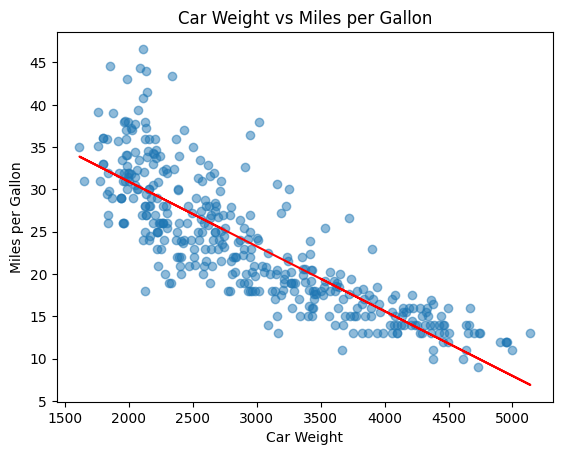

In [7]:
# Your code here

df = pd.read_csv('car_data.csv')
weight = np.array(df["weight"])
mpg = np.array(df["MPG"])

fit = linearModelFit(weight, mpg, lossfcn)
betas = fit[0]
print(f"The recommended parameters are {betas}")
weight_calculation = np.column_stack((np.ones(weight.shape[0]), weight))
y_hat = weight_calculation @ betas
print(f"The R-squared of this regression is {fit[1]}")



plt.scatter(weight, mpg, alpha=0.5)
plt.plot(weight, y_hat, color = 'r')
plt.xlabel("Car Weight")
plt.ylabel("Miles per Gallon")
plt.title("Car Weight vs Miles per Gallon")
plt.show()


**Your answer here:** The R-squared for this model is 0.6926304331206254. About 69.26% of the variation in this model can be explained by the predictor

### Question 1.6:

Now use sklearn's `linear_model` to fit the model with all the available data. Plot the data and add a line for the predicted values as you did in the previous question. Also report the $R^2$ value for the fit.

**Written answer: How much do you gain by having more variables?**

[-0.00764734]
0.6926304331206254


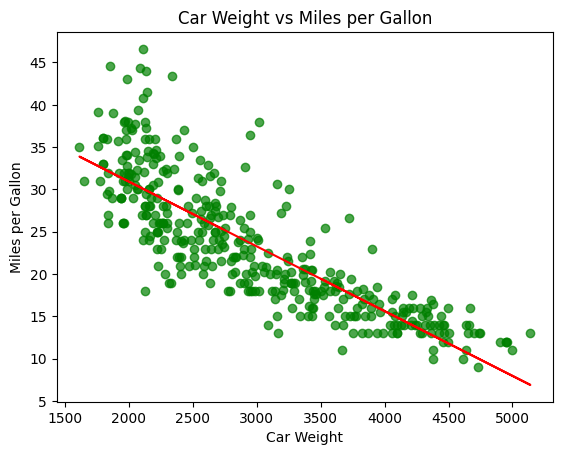

In [8]:
# Your code here

model = linear_model.LinearRegression(fit_intercept=True)
weight = weight.reshape(weight.shape[0], -1)
model.fit(weight,mpg)
print(model.coef_)
print(model.score(weight, mpg))

plt.scatter(weight, mpg, color='g', alpha=0.7)
plt.plot(weight, model.predict(weight), color='r')
plt.xlabel("Car Weight")
plt.ylabel("Miles per Gallon")
plt.title("Car Weight vs Miles per Gallon")
plt.show()


**Your answer here.** We practically did not gain anything by having more variables. The R-squared is the same at 69.263043312%. This is because the linear regression uses least-squares, as we did

## Part 2: LAD Regression

### Question 2.1:

In the previous section, we worked with the squared loss.  Now, we'll implement a linear model with least absolute deviation loss $LAD(y_i, \hat{y_i})$.

$$
LAD(y_i, \hat{y_i}) = \frac{1}{|I|}\sum_i |y_i - \hat{y_i}|
$$

where $y_i$ is the true label of sample $i \in I$, $\hat{y_i}$ is the prediction, $I$ is the sample set, and $|I|$ is the number of cases in the sample. The gradient of the function is:

$$
\nabla LAD(y, \hat{y}) = - \frac{ sign(y_i - \hat{y_i}) \cdot X}{|I|}
$$

with `sign` the sign function. Note this function is undefined at 0.

Write a function `linearModelLossLAD` which computes the least absolute deviation loss function for a linear model parameterized by $\beta$, as well as the gradient of the loss, following the same structured as the previous part.

Test the function with the values

```
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2])
```

Report the loss and the gradient.

In [9]:
# Your code here

def linearModelLossLAD(beta, X, y):
    yp = X@beta
    y_pred = yp.reshape(-1,1)
    y_real = np.array(y).reshape(-1,1)
    assert y_real.shape == y_pred.shape
    loss = np.mean(abs(y_real-y_pred))
    gradientLAD = -(np.sign(y_real-y_pred).T @ X)/len(y_real)
    gradientLAD = gradientLAD.flatten()
    return loss, gradientLAD

X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2])
    
linearModelLossLAD(beta=np.array([0.1,0.3]), X=np.array([[1,0],[1,-1],[1,2]]), y=np.array([0,0.4,2]))

(np.float64(0.6666666666666666), array([-0.33333333, -0.33333333]))

### Question 2.2:


Use the above functions to fit your LAD model using the weight variable as input, to predict the mpg. Use your model to make predictions along a grid of 100 equally spaced car weights.  Once fit, add the fitted line to the scatter plot as in question 1.5.  Also report the $R^2$-value.

**Written answer**: What is the difference in the fit obtained with an $L_1$ as compared to the $L_2$ cost function? How do their $R^2$ values compare? Why?  

Note: If you receive an error from the optimizer, it may be because the loss function for the LAD model is not differentiable at its minimum.  This will lead to some gradient-based optimizers to fail to converge.  If this happens to you then pass `method="Powell"` to `scipy.optimize.minimize`.



The recommended parameters for the LSE are [ 4.62165245e+01 -7.64734254e-03]
The R-squared of the LSE regression is 0.6926304331206254
The recommended parameters for the LAD regression are [ 4.41061632e+01 -7.10610392e-03]
The R-squared for the LAD regression is 0.6850667304849745


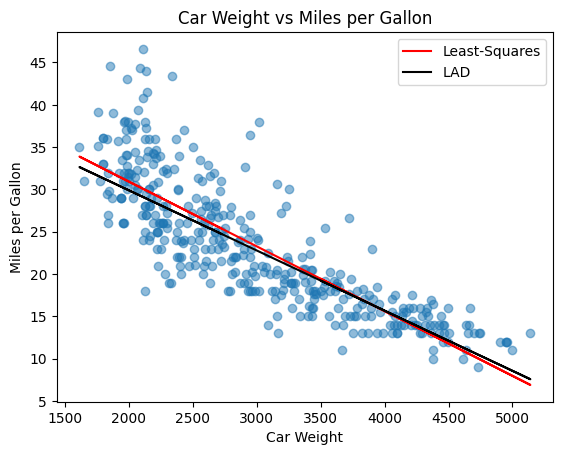

In [10]:
# Your code here

df = pd.read_csv('car_data.csv')
weight = np.array(df["weight"])
mpg = np.array(df["MPG"])

fit = linearModelFit(weight, mpg, lossfcn)
betaslse = fit[0]
print(f"The recommended parameters for the LSE are {betas}")
weight_calculation = np.column_stack((np.ones(weight.shape[0]), weight))
y_hat = weight_calculation @ betas
print(f"The R-squared of the LSE regression is {fit[1]}")

ladfit = linearModelFit(weight,mpg,linearModelLossLAD)
betasLAD = ladfit[0]
print(f"The recommended parameters for the LAD regression are {betasLAD}")
y_hat_lad = weight_calculation @ betasLAD
print(f"The R-squared for the LAD regression is {ladfit[1]}")



plt.scatter(weight, mpg, alpha=0.5)
plt.plot(weight, y_hat, color = 'r', label='Least-Squares')
plt.plot(weight, y_hat_lad, color = 'k', label = 'LAD')
plt.legend()
plt.xlabel("Car Weight")
plt.ylabel("Miles per Gallon")
plt.title("Car Weight vs Miles per Gallon")
plt.show()





**Your answer here.** The least-squares regression method has a slightly higher intercept and a steeper slope, while the LAD regression is a bit flatter with a shorter intercept. Additionally, it appears that the least-squares is marginally as an explanation of the regression with a 0.6926 R-squared vs the LAD regression with 0.6851 R-squared

### Question 2.3:

Now we will use all data for the fit. Fit an LAD model to the car data (excluding the name) with the `linear_model` module from the `sklearn` package by using the [`QuantileRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor) class that implements a [pinball loss](https://en.wikipedia.org/wiki/Quantile_regression), a more general case of the [`mean_absolute_error`](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_absolute_error.html) loss. To get an MAD regression, set the parameters `alpha=0` and `quantile=0.5` in the `QuantileRegressor` call.

In no more than two sentences, comment on the $R^2$ values for both the OLS and MAD regressions. Use the `sklearn` models for this analysis. Are they similar? Make a scatterplot of the sklearn's OLS and MAD predictions.

OLS coefficients: [-0.0071048]
OLS R squared 0.6850622675587247
MAD coefficient [-0.00764734]
MAD R squared 0.6926304331206254


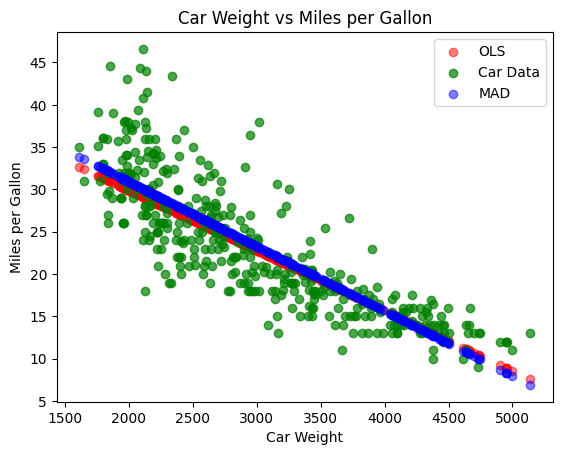

In [12]:
# Your code here

df = pd.read_csv('car_data.csv')
weight = np.array(df["weight"])
mpg = np.array(df["MPG"])
weight = weight.reshape(weight.shape[0], -1)

model = linear_model.QuantileRegressor(alpha=0, quantile =0.5)
model.fit(weight, mpg)
print(f"OLS coefficients: {model.coef_}")
print(f"OLS R squared {model.score(weight,mpg)}")

plt.scatter(weight, model.predict(weight), color='r', alpha=0.5, label='OLS')


model2 = linear_model.LinearRegression(fit_intercept=True)
model2.fit(weight,mpg)
print(f"MAD coefficient {model2.coef_}")
print(f"MAD R squared {model2.score(weight, mpg)}")

plt.scatter(weight, mpg, color='g', alpha=0.7, label='Car Data')
plt.scatter(weight, model2.predict(weight), color='b', alpha=0.5, label='MAD')
plt.xlabel("Car Weight")
plt.ylabel("Miles per Gallon")
plt.title("Car Weight vs Miles per Gallon")
plt.legend()
plt.show()




**Your answer here.** Yes, the $R^2$ values for OLS and MAD are similar. A difference of less than 1% is not a big enough difference to necessarily choose one model over another.